In [1]:
import numpy as np
import json
import os
import sys
import time
import random
import matplotlib.pyplot as plt

from mosaicing_demosaicing_v2_tf import *
from image_transformer_tf import ImageTransformer
from utils_tf import *


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import nn
from tensorflow.keras import optimizers
from keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

C:\Users\rohan\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Morie_attack():
    r"""
    Distance Measure : L_inf bound on sensor noise
    Arguments:
        model (nn.Module): Victim model to attack.
        steps (int): number of steps. (DEFAULT: 50)
        batch_size (int): batch size
        scale_factor (int): zoom in the images on the LCD. （DEFAULT: 3）

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`, `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    """

    def __init__(self, model, img_h, img_w, noise_budget, scale_factor, steps = 50, batch_size = 50, targeted = False):
        super(Morie_attack, self).__init__("Morie_attack", model)
        self.steps = steps
        self.targeted = targeted
        self.img_w = img_w
        self.img_h = img_h
        self.scale_factor = scale_factor
        self.noise_budget = noise_budget
        self.lr = noise_budget / steps
        noise = np.zeros([batch_size, self.img_h * self.scale_factor * 3, self.img_w * self.scale_factor * 3])
        self.noise = tf.convert_to_tensor(noise)
        self.noise.requires_grad = True
        self.adv_loss = nn.CrossEntropyLoss()

    def simulate_LCD_display(self, input_img):
        """ Simulate the display of raw images on LCD screen
        Input:
            original images (tensor): batch x height x width x channel
        Output:
            LCD images (tensor): batch x (height x scale_factor)  x (width x scale_factor) x channel
        """
        input_img = input_img.numpy()
        batch_size, h, w, c = input_img.shape

        simulate_imgs = np.zeros((batch_size, h * 3, w * 3, 3), dtype=np.float32)
        red = np.repeat(input_img[:, :, :, 0], 3, axis = 1)
        green = np.repeat(input_img[:, :, :, 1], 3, axis = 1)
        blue = np.repeat(input_img[:, :, :, 2], 3, axis = 1)

        for y in range(w):
            simulate_imgs[:, :, y * 3, 0] = red[:, :, y]
            simulate_imgs[:, :, y * 3 + 1, 1] = green[:, :, y]
            simulate_imgs[:, :, y * 3 + 2, 2] = blue[:, :, y]
        simulate_imgs = tf.convert_to_tensor(simulate_imgs)

        return simulate_imgs

    def demosaic_and_denoise(self, input_img):
        """ Apply demosaicing to the images
        Input:
            images (tensor): batch x (height x scale_factor) x (width x scale_factor)
        Output:
            demosaicing images (tensor): batch x (height x scale_factor) x (width x scale_factor) x channel
        """
        demosaicing_imgs = demosaicing_CFA_Bayer_bilinear(input_img)
        return demosaicing_imgs

    def simulate_CFA(self, input_img):
        """ Simulate the raw reading of the camera sensor using bayer CFA
        Input:
            images (tensor): batch x (height x scale_factor) x (width x scale_factor) x channel
        Output:
            mosaicing images (tensor): batch x (height x scale_factor) x (width x scale_factor)
        """
        mosaicing_imgs = mosaicing_CFA_Bayer(input_img)
        return mosaicing_imgs

    def random_rotation_3(self, org_images, lcd_images):
        """ Simulate the 3D rotatation during the shooting
        Input:
            images (tensor): batch x height x width x channel
        Rotate angle:
            theta (int): (-20, 20)
            phi (int): (-20, 20)
            gamma (int): (-20, 20)
        Output:
            rotated original images (tensor): batch x height x width x channel
            rotated LCD images (tensor): batch x (height x scale_factor) x (width x scale_factor) x channel
        """
        rotate_images = np.zeros(org_images.size())
        rotate_lcd_images = np.zeros(lcd_images.size())

        for n, img in enumerate(org_images):
            Trans_org = ImageTransformer(img)
            theta, phi, gamma, rotate_img = Trans_org.rotate_along_axis(True)
            rotate_images[n, :] = rotate_img
            Trans_lcd = ImageTransformer(lcd_images[n])
            _, _, _, rotate_lcd_img = Trans_lcd.rotate_along_axis(False, theta, phi, gamma)
            rotate_lcd_images[n, :] = rotate_lcd_img

        rotate_images = tf.convert_to_tensor(rotate_images)
        rotate_lcd_images = tf.convert_to_tensor(rotate_lcd_images)

        return rotate_images, rotate_lcd_images

    def forward(self, org_imgs, org_labels, targeted_labels):
        r"""
        Overridden.
        """
        org_images = org_imgs.clone()
        org_labels = org_labels.clone()
        org_labels = self._transform_label(org_images, org_labels)

        # compute the orignal prediction
        temp_outputs = self.model(org_imgs.clone())
        org_percentage = tf.nn.softmax(temp_outputs, dim=1) * 100 #change dim to axis
        del temp_outputs
        
        resize_before_lcd = tf.image.resize(org_images, scale_factor = self.scale_factor, method="bilinear") #check scale conversion how to do
        resize_before_lcd = tf.transpose(resize_before_lcd, perm=[0, 2, 3, 1])
        lcd_images = self.simulate_LCD_display(resize_before_lcd)

        temp_images = tf.transpose(org_images.clone(), perm=[0, 2, 3, 1])

        rotate_images, rotate_lcd_images = self.random_rotation_3(temp_images, lcd_images)
        # rotate_images = rotate_images.to(self.device)
        # rotate_lcd_images = rotate_lcd_images.to(self.device).detach()

        dim_images = adjust_contrast_and_brightness(rotate_images, beta=-60)

        ## compute the rotate prediction
        rotate_images = rotate_images.permute(0, 3, 1, 2)
        rotate_images = rotate_images.float()
        rotate_outputs = self.model(rotate_images)
        _, rotate_pre = tf.math.reduce_max(rotate_outputs.data, 1)
        rotate_percentage = tf.nn.softmax(rotate_outputs.clone(), dim=1) * 100 # dim to axis

        ## compute the dim prediction
        dim_images = tf.transpose(dim_images, perm=[0, 3, 1, 2])
        dim_images = dim_images.float()
        dim_outputs = self.model(dim_images)
        _, dim_pre = tf.math.reduce_max(dim_outputs.data, 1)
        dim_percentage = tf.nn.softmax(dim_outputs.clone().detach(), dim=1) * 100 # dim to axis


        ## Deliver the MA
        for step in range(self.steps):
            print("Step: {}/{}".format(step, self.steps))

            cfa_img = self.simulate_CFA(rotate_lcd_images)
            cfa_img_noise = cfa_img + self.noise

            demosaic_img = self.demosaic_and_denoise(cfa_img_noise)
            demosaic_img = demosaic_img.permute(0, 3, 1, 2)

            ## Adjust the brightness
            brighter_img = adjust_contrast_and_brightness(demosaic_img, beta=20)

            at_images = tf.image.resize(brighter_img, [299, 299], method='bilinear')
            at_images = at_images.float()
            at_outputs = self.model(at_images)
            _, at_pre = tf.math.reduce_max(at_outputs.data, 1)

            at_percentage = tf.nn.softmax(at_outputs.clone(), dim=1) * 100 # dim to axis

            if self.targeted:
                adv_cost = self.adv_loss(at_outputs, (tf.cast(targeted_labels, tf.int64)))
            else:
                adv_cost = -1 * self.adv_loss(at_outputs, org_labels)

            total_cost = adv_cost
            print("Loss: ", total_cost, "Adv loss: ", adv_cost)
    
            with tf.GradientTape() as tape:
                total_cost = adv_cost
            grads = tape.gradient(total_cost, self.noise)
            self.noise = tf.stop_gradient(self.noise) - self.lr * tf.sign(grads)
            self.noise = tf.clip_by_value(self.noise, clip_value_min=-self.noise_budget, clip_value_max=self.noise_budget)
            self.noise = tf.Variable(self.noise, trainable=True)

        at_images = tf.clip_by_value(at_images, min=0, max=255)

        return at_images, rotate_images, dim_images, \
               at_pre, rotate_pre, dim_pre, \
               org_percentage, at_percentage, rotate_percentage, dim_percentage

In [3]:
class Normalize(tf.keras.layers.Layer):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = tf.constant(mean, dtype=tf.float32)
        self.std = tf.constant(std, dtype=tf.float32)

    def call(self, input):
        input = input / 255.0
        mean = tf.reshape(self.mean, shape=(1, 1, 1, 3))
        std = tf.reshape(self.std, shape=(1, 1, 1, 3))
        return (input - mean) / std

In [18]:
STEPS = 10

class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
class2label = [class_idx[str(k)][0] for k in range(len(class_idx))]

transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(299, 299),
    tf.keras.layers.experimental.preprocessing.Normalization(
        mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225]
    ),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

model = Sequential([
    norm_layer,
    InceptionV3(weights='imagenet')
])

model = model.compile()

## Save the results of MA
## SET TO TRUE IF WE WANT TO SAVE THE OUTPUT IMAGES
Save_results = 'True'
if Save_results == 'True':
    savedir = './Results'
    adv_dir = os.path.join(savedir, 'adv')
    rotate_dir = os.path.join(savedir, 'rotate')
    org_dir = os.path.join(savedir, 'org')
    dim_dir = os.path.join(savedir, 'dim')
    create_dir(adv_dir)
    create_dir(rotate_dir)
    create_dir(org_dir)
    create_dir(dim_dir)

## default settings
noise_budget = 2
batch_size = 10
epoch = 1#int(1000 / batch_size)
total = 0
suc_cnt_at = 0
suc_cnt_dim = 0
suc_cnt_rotate = 0


normal_data = image_folder_custom_label(root='./data/dataset/incepv3_data',
                                        transform=transform,
                                        idx2label=class2label)

normal_loader = tf.keras.utils.image_dataset_from_directory('./data/dataset/incepv3_data')
targeted = False
print("-" * 70)
print("Noise_budget = ", noise_budget)
start = time.time()
for batch in range(epoch):

    print("-" * 70)
    org_imgs, org_labels, targeted_labels = np.zeros((224,224), dtype=np.float32), [0], [0]
    rotate_labels = [0]
    org_imgs = org_imgs * 255.0
    
    org_labels = np.array([0])
    targeted_labels = np.array([0])
    rotate_labels = np.array([0])
    at_labels, dim_labels = np.array([1000]), np.array([1000])

    ## compute the succes rate
    total += batch_size

    Succ_cnt_rotate = (rotate_labels != org_labels) / batch_size
    Succ_total_rotate = suc_cnt_rotate / total
    Succ_cnt_dim = (dim_labels != org_labels) / batch_size
    Succ_total_dim = suc_cnt_dim / total
    if targeted:
        Succ_cnt_at = (at_labels == targeted_labels) / batch_size
        Succ_total_at = suc_cnt_at / total
    else:
        Succ_cnt_at = (at_labels != org_labels) / batch_size
        Succ_total_at = suc_cnt_at / total
        
    # Setting default variables
    true_class='tench'
    percentage_org=50
    rotate_class='bayer'
    percentage_rotate=30
    dim_class='tench'
    percentage_dim=20

    # save the pics
    for i in range(batch_size):

        if Save_results == 'True':
            # save org_images
            img_org_name = true_class + str(percentage_org) + ".JPEG"
            img_org_path = os.path.join(org_dir, img_org_name)

            # uncomment the following if you want to save the intermediate results
            # save rotated_images:
            img_rotate_name = true_class + str(percentage_org) + "_" + rotate_class + str(percentage_rotate) + ".JPEG"
            img_rotate_path = os.path.join(rotate_dir, img_rotate_name)

            # save dim_images:
            img_dim_name = true_class + str(percentage_org) + "_" + dim_class + str(percentage_dim) + ".JPEG"
            img_dim_path = os.path.join(dim_dir, img_dim_name)

            ##  save at_images:
            img_at_name = true_class + str(percentage_org) + "_"  + ".JPEG"
            img_at_path = os.path.join(adv_dir, img_at_name)


    del  rotate_labels, dim_labels, \
        org_labels, targeted_labels, \
        org_imgs

Found 2 images belonging to 1 classes.
Found 2 images belonging to 1 classes.
Found 2 files belonging to 1 classes.
----------------------------------------------------------------------
Noise_budget =  2
----------------------------------------------------------------------


In [17]:
root_dir = os.getcwd()
os.getcwd()

'C:\\Users\\rohan\\OneDrive\\Documents\\Github\\Moire_Attack'

In [6]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

clean_path, moire_path = os.path.join('sample_data', 'n01440764'), os.path.join(os.path.join('sample_data', 'adv'))

clean_imgs, moire_imgs = [], []

os.chdir(clean_path)
for img in os.listdir():
    img = load_img(img)
    img = img_to_array(img)
    clean_imgs.append(img)
clean_imgs = np.array(clean_imgs)
os.chdir(root_dir)
os.chdir(moire_path)
for img in os.listdir():
    img = load_img(img)
    img = img_to_array(img)
    moire_imgs.append(img)
moire_imgs = np.array(moire_imgs)


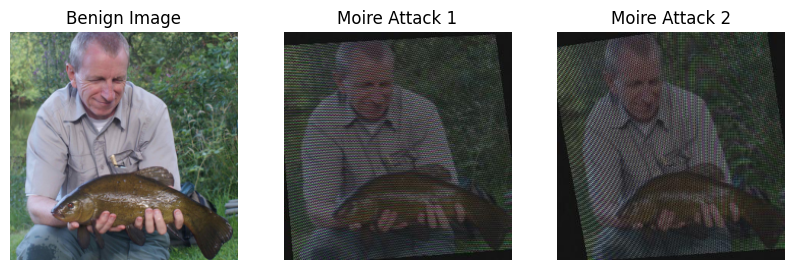

In [8]:
rand1, rand2 = random.randint(0, 5), random.randint(0, 5) 
plt.figure(figsize=(10, 4))

plt.subplot(1,3,1)
plt.axis('off')
plt.title('Benign Image')
plt.imshow(np.uint8(clean_imgs[0]))

plt.subplot(1,3,2)
plt.title('Moire Attack 1')
plt.axis('off')
plt.imshow(np.uint8(moire_imgs[rand1]))

plt.subplot(1,3,3)
plt.title('Moire Attack 2')
plt.axis('off')
plt.imshow(np.uint8(moire_imgs[rand2]))

# Beyond the experiment

## MNIST Dataset

In [9]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Reshape the images to fit the CNN input
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Define the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the original images
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

Epoch 1/5
938/938 [==============================] - 31s 33ms/step - loss: 0.1873 - accuracy: 0.9426 - val_loss: 0.0764 - val_accuracy: 0.9745
Epoch 2/5
938/938 [==============================] - 30s 32ms/step - loss: 0.0501 - accuracy: 0.9845 - val_loss: 0.0342 - val_accuracy: 0.9885
Epoch 3/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0334 - accuracy: 0.9894 - val_loss: 0.0360 - val_accuracy: 0.9889
Epoch 4/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0259 - accuracy: 0.9924 - val_loss: 0.0289 - val_accuracy: 0.9908
Epoch 5/5
938/938 [==============================] - 32s 34ms/step - loss: 0.0201 - accuracy: 0.9940 - val_loss: 0.0263 - val_accuracy: 0.9914


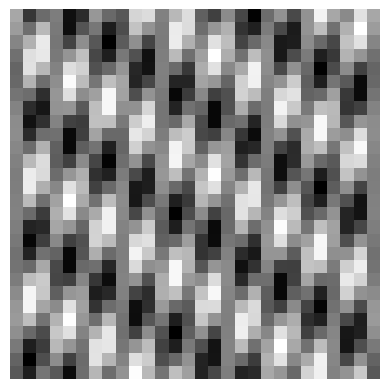

In [10]:
# Create a grid of x and y values
x, y = np.meshgrid(np.linspace(-1, 1, 28), np.linspace(-1, 1, 28))

# Define two sine waves with slightly different frequencies and phases
w1 = np.sin(5*np.pi*x + 0.1*np.pi*y)
w2 = np.cos(3*np.pi*x + 3*np.pi*y)

# Combine the two waves to create a moiré pattern
moire = w1 * w2

moire = np.array((moire).astype(np.float32)).reshape([28, 28, 1])
# Display the pattern using Matplotlib
plt.imshow((moire), cmap='gray')
plt.axis('off')
plt.show()
m = np.dstack((moire,moire,moire))

## Generate Moire pattern

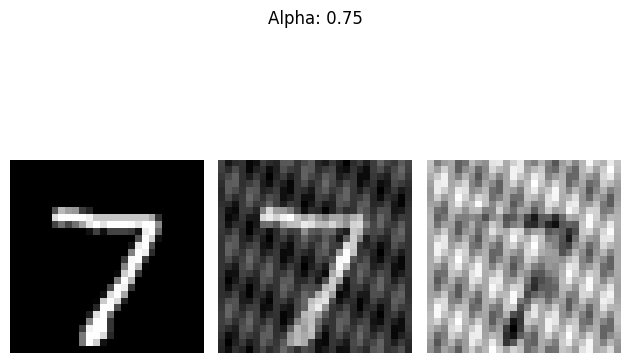

313/313 [==============================] - 2s 7ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.964900016784668


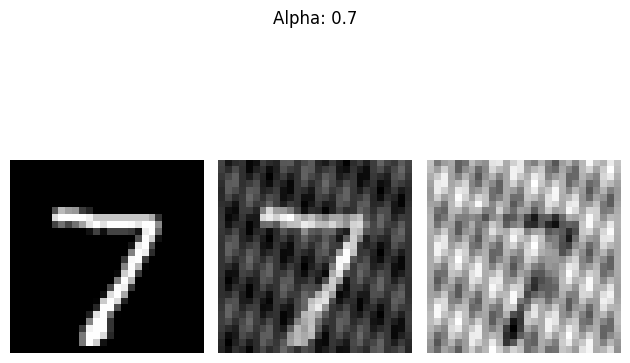

313/313 [==============================] - 3s 9ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.9498000144958496


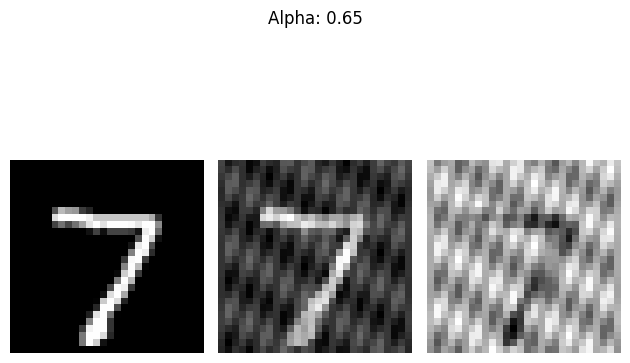

313/313 [==============================] - 3s 8ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.9200000166893005


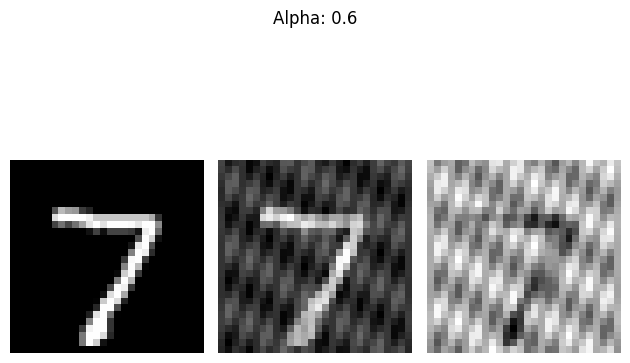

313/313 [==============================] - 2s 6ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.882099986076355


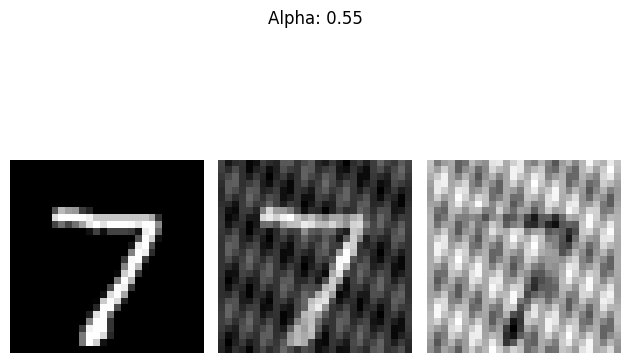

313/313 [==============================] - 2s 7ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.8130999803543091


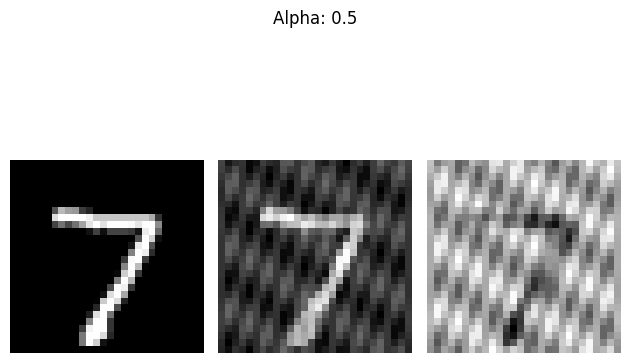

313/313 [==============================] - 3s 8ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.7160000205039978


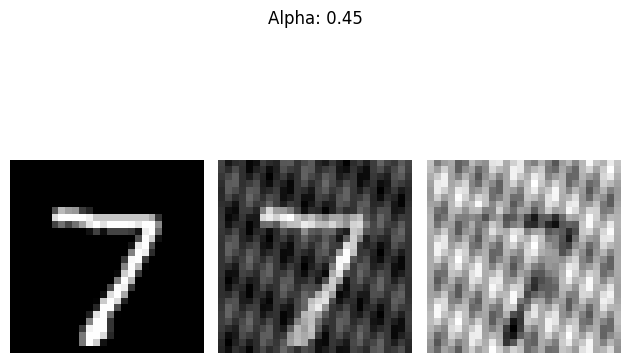

313/313 [==============================] - 2s 6ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.5993000268936157


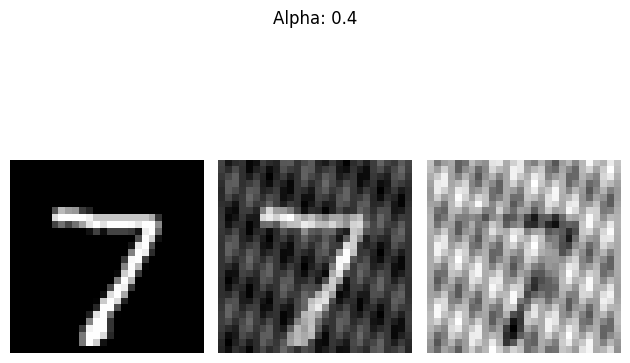

313/313 [==============================] - 2s 6ms/step - loss: 0.0263 - accuracy: 0.9914
Test accuracy (original images): 0.9914000034332275
Test accuracy (images with moiré patterns): 0.487199991941452


In [11]:
alpha_val = [0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4]
clean_acc = []
moire_acc = []
masked_img = []

def generate_moire_images(image, alpha=0.4):
    beta = (1.0 - alpha)
    gamma = np.random.random()
    masked = cv2.addWeighted(image, alpha, moire, beta, gamma)
    masked = np.array(masked).reshape([28, 28, 1])
    masked_img.append(masked)
    return masked

for alphas in alpha_val:
    moire_images = [generate_moire_images(test_image, alpha=alphas) for test_image in test_images]
    moire_images = np.array(moire_images)
   
    plt.suptitle(f'Alpha: {alphas}')
    plt.subplot(1,3,1)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(test_images[0], cmap='gray')
    
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(masked_img[0], cmap='gray')
    
    plt.subplot(1,3,3)
    plt.axis('off')
    plt.tight_layout()
    plt.imshow(abs(test_images[0] - masked_img[0]), cmap='gray')
    plt.show()
    
    # Evaluate the model on the test images with moiré patterns
    test_loss_moire, test_acc_moire = model.evaluate(moire_images, test_labels)
    moire_acc.append(test_acc_moire)
    # Evaluate the model on the original test images
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    clean_acc.append(test_acc)
    
    print(f'Test accuracy (original images): {test_acc}')
    print(f'Test accuracy (images with moiré patterns): {test_acc_moire}')

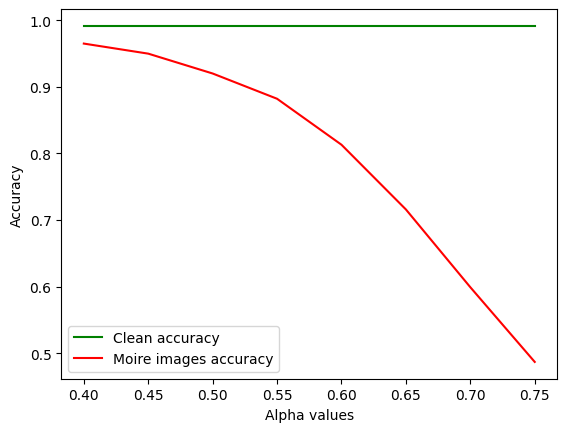

In [12]:
plt.xlabel('Alpha values')
plt.ylabel('Accuracy')
plt.plot(alpha_val[::-1], clean_acc, c='green')
plt.plot(alpha_val[::-1], moire_acc, c='red')
plt.legend(['Clean accuracy', 'Moire images accuracy'])